In [1]:
%pylab inline

# Import our plot library
from vplot import *

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from matplotlib.patches import Polygon
import scipy.stats
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import seaborn as sns; sns.set(style="white", color_codes=True)

SIMDIR="/storage/ileena/simulation/SSC/fig_haplo_paper/"
DATADIR="/storage/mgymrek/ssc-imputation/"
OUTPATH="pdfs/"
PREFIX="Figure4"

Populating the interactive namespace from numpy and matplotlib


# Supplementary Figure: Allelic Parabolic

In [2]:
# Functions for plotting

def PlotExample(ex_data, fname, color="black"):
    lw=1
    boxprops = dict(color=color, linewidth=lw)
    medianprops = dict(color=color, linewidth=lw)
    fig = plt.figure()
#     fig.set_size_inches((8, 4))
    ax = fig.add_subplot(111)
    bp = ex_data.boxplot(column="pt", by="gt", ax=ax, grid=False, boxprops=boxprops, medianprops=medianprops,
                return_type='dict');

    [[item.set_linewidth(lw) for item in bp[key]['boxes']] for key in bp.keys()]
    [[item.set_linewidth(lw) for item in bp[key]['fliers']] for key in bp.keys()]
    [[item.set_linewidth(lw) for item in bp[key]['medians']] for key in bp.keys()]
    [[item.set_linewidth(lw) for item in bp[key]['means']] for key in bp.keys()]
    [[item.set_linewidth(lw) for item in bp[key]['whiskers']] for key in bp.keys()]
    [[item.set_linewidth(lw) for item in bp[key]['caps']] for key in bp.keys()]
    [[item.set_color(color) for item in bp[key]['boxes']] for key in bp.keys()]
    [[item.set_color(color) for item in bp[key]['fliers']] for key in bp.keys()]
    [[item.set_color(color) for item in bp[key]['medians']] for key in bp.keys()]
    [[item.set_color(color) for item in bp[key]['whiskers']] for key in bp.keys()]
    [[item.set_color(color) for item in bp[key]['caps']] for key in bp.keys()]

    ax.set_title("")
    plt.suptitle("");
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    ax.set_xlabel("STR Genotype (bp relative to hg19)", size=20)
    ax.set_ylabel("Simulated phenotype", size=20);
    ax.set_xticklabels(ax.get_xticklabels(), size=15);
#     ax.set_yticks(np.arange(-3, 3.1, 1))
    ax.set_yticklabels(ax.get_yticks(), size=15);
    fig.savefig(fname)
    
def PlotR2Pval(r2_snp, r2_imp, assoc, fname):
    # Pull out SNPs
    str_coord = assoc[assoc["testclass"]=="STR"]["locus"].values[0]
    r2 = r2_snp[r2_snp["locus1"]==str_coord]
    r2["locus"] = r2["locus2"] #SNP locus
    snp_assoc = assoc[assoc["testclass"]=="SNP"]
    snp_assoc = pd.merge(snp_assoc, r2, on=["locus"])

    fig = plt.figure()
    fig.set_size_inches((6, 4))
    ax = fig.add_subplot(111)
    
    # Plotting all SNPs
    ax.scatter(snp_assoc["r2"], snp_assoc["pvalue"].apply(lambda x: -1*np.log10(x)), color="gray", s=8, label="SNPs");
    # Plot all STR allele tests 
    str_y = assoc[assoc["testclass"]=="STR"]["pvalue"].apply(lambda x: -1*np.log10(x)).values[:]
    str_x = np.repeat(1.0, len(str_y))
    ax.scatter(str_x, str_y, color="red", s=40, label="STR")
    # Plot all imputed STR allele tests 
    imp_ld = r2_imp[r2_imp["locus1"]==str_coord]["r2"].values[:]
    imp_p = assoc[assoc["testclass"]=="IMPSTR"]["pvalue"].apply(lambda x: -1*np.log10(x)).values[:]
    imp_x = np.repeat(imp_ld, len(imp_p))
    ax.scatter(imp_x, imp_p, color="blue", s=40, label="Imputed STR");
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    ax.set_xlabel("R2 with causal STR", size=15)
    ax.set_ylabel("-log10 P", size=15);
    ax.set_xticklabels(["%.1f"%x for x in ax.get_xticks()], size=12)
    ax.set_yticklabels(["%.1f"%x for x in ax.get_yticks()], size=12)
    ax.legend(loc="upper left");
    fig.savefig(fname)
    
def GetPower(x, alpha=0.05):
    return np.mean([(int(float(item) < alpha)) for item in x])

def PlotPower(assoc, fname, alpha=0.05):
    # Calculate power for each class
    assoc_tmp = assoc.groupby(["str","testclass"], as_index=False).agg({"pvalue": lambda x: GetPower(x)})
    assoc_tmp["power"] = assoc_tmp["pvalue"]
    assoc_tmp = assoc_tmp[["str","testclass","power"]]
    impdata = assoc_tmp[assoc_tmp["testclass"]=="IMPSTR"].copy()
    snpdata = assoc_tmp[assoc_tmp["testclass"]=="SNP"].copy()
    strdata = assoc_tmp[assoc_tmp["testclass"]=="STR"].copy()
    impdata["imp_power"] = impdata["power"]
    snpdata["snp_power"] = snpdata["power"]
    strdata["str_power"] = strdata["power"]
    power = pd.merge(impdata[["str","imp_power"]], snpdata[["str", "snp_power"]], on=["str"])
    power = pd.merge(power, strdata[["str","str_power"]], on=["str"])
    power["powerdiff"] = power["imp_power"] - power["snp_power"]
    power["locus"] = power["str"]
    data = pd.merge(power, r2comp, on=["locus"])
    g = sns.jointplot(x="r2diff", y="powerdiff", data=data, color="black", edgecolor="black", 
                      annot_kws={"loc":0, "bbox_to_anchor":(0.45, 0.15)})
    g.ax_joint.axvline(x=0, linestyle="dashed", color="gray")
    g.ax_joint.axhline(y=0, linestyle="dashed", color="gray")
    g.ax_joint.set_xlabel("r2imp-r2bestsnp", size=15)
    g.ax_joint.set_ylabel("powerimp-powerbestsnp", size=15)
    g.savefig(fname)
    print(data.shape[0])
    print(np.mean(data["r2diff"]))
    print(np.mean(data["powerdiff"]))

# Figure 4

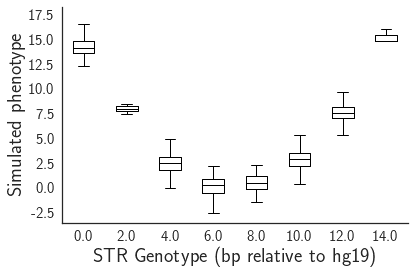

In [3]:
# Load data 
exp_gt_data = pd.read_csv(os.path.join(SIMDIR, "suppl_chr21_23934706_pb_allelic.gt"), sep="\t")
exp_pt_data = pd.read_csv(os.path.join(SIMDIR,"suppl_chr21_23934706_pb_allelic_0.pheno"), sep="\t", names=["Sample_ID", "x", "pt"])
ex_data = pd.merge(exp_gt_data, exp_pt_data, on=["Sample_ID"])
ex_data["gt"] = ex_data["True_STR_Sum"]
# Fig A
PlotExample(ex_data, os.path.join(SIMDIR, OUTPATH, "SuppFig_PB_ExampleAssociation.pdf"))

In [4]:
# Do Not need for Haplotype paper
# # Load LD values
# r2_snp = pd.read_csv(os.path.join(DATADIR, "gwas-power", "r2_snp.tab"), sep="\t")
# r2_imp = pd.read_csv(os.path.join(DATADIR, "gwas-power", "r2_imp.tab"), sep="\t")

# # Assoc results
# exassoc = pd.read_csv(os.path.join(SIMDIR, "suppl_chr21_23934706_pb_allelic_power_simulation_results.txt"), sep="\t")

# # Fig B
# PlotR2Pval(r2_snp, r2_imp, exassoc, os.path.join(SIMDIR, OUTPATH, "SuppFig_PB_r2vsP.pdf"))


In [5]:
# Load LD values
r2_snp = pd.read_csv(os.path.join(DATADIR, "gwas-power", "r2_snp.tab"), sep="\t")
r2_imp = pd.read_csv(os.path.join(DATADIR, "gwas-power", "r2_imp.tab"), sep="\t")
best_snp = r2_snp.groupby("locus1", as_index=False).agg({"r2": max, "freq_het": np.mean})
r2comp = pd.merge(best_snp, r2_imp, on=["locus1"])[["locus1","freq_het_x","r2_x","r2_y"]]
r2comp.columns = ["locus","het","r2_bestsnp","r2_ssc"]
r2comp["r2diff"] = r2comp["r2_ssc"]-r2comp["r2_bestsnp"]


5784
0.17644800861568083
0.17611671696215267


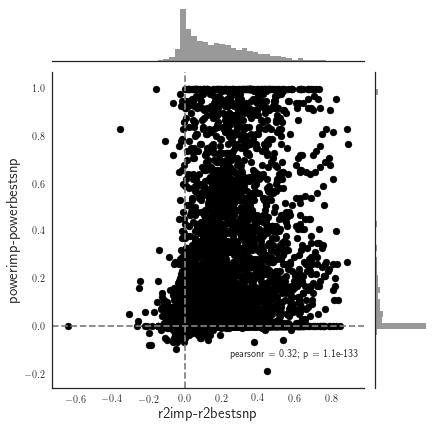

In [8]:
# Sim Power results - For best allele
assoc = pd.read_csv(os.path.join(SIMDIR, "suppl_chr21_pb_allelic_b0.1_power_simulation_results.txt"), sep="\t")
###keep only min p-value for STR
assoc_filt = assoc.groupby(["simnum", "str", "testclass"],  as_index=False).pvalue.min()

PlotPower(assoc_filt, os.path.join(SIMDIR, OUTPATH, "SuppFig_PB_Allele_GWASPower.pdf"), alpha=0.05)

In [ ]:
# Sim Power results - Non allelic
assoc = pd.read_csv(os.path.join(SIMDIR, "suppl_chr21_pb_b0.1_power_simulation_results.txt"), sep="\t")
PlotPower(assoc, os.path.join(SIMDIR, OUTPATH, "SuppFig_PB_GWASPower.pdf"), alpha=0.05)